In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gc
import re

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from itertools import cycle
from IPython.display import display
import pickle, os

import seaborn as sns

BES_data_folder = "../BES_analysis_data/"
BES_code_folder = "../BES_analysis_code/"

from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute, MICE

Using Theano backend.


In [2]:
%%time
BES_Panel   = pd.read_stata( BES_data_folder+"BES2015_W8_v1.3.dta") # 130Mb
print("BES_Panel", BES_Panel.shape )
BES_numeric = pd.read_hdf( BES_data_folder+"BESW8numeric.hdf", "BESW8numeric" )
print("BES_numeric",  BES_numeric.shape )
var_type    = pd.read_hdf( BES_data_folder+"var_type.hdf", "var_type" )
print("var_type",  var_type.shape )

BES_Panel (31409, 733)
BES_numeric (31409, 659)
var_type (733, 1)
Wall time: 13.7 s


In [3]:
fname = BES_data_folder+"cat_dictionary"+".pkl"
with open(fname, "rb") as f:
    cat_dictionary = pickle.load( f )

In [4]:
imputation_method = "mice" # "mice", "softimpute", "median", ???

imputed_file_name = "BESW8" + imputation_method

BES_imputed = pd.read_hdf( BES_data_folder + imputed_file_name  + ".hdf", imputed_file_name )
print("BES_imputed",  BES_imputed.shape )

BES_imputed (31409, 378)


In [5]:
England_inds = BES_Panel[BES_Panel["country"]=="England"].index
print ( "respondents not from England: ", len(BES_Panel) - len(England_inds) )
Remain_inds  = BES_Panel[ BES_Panel["euRefVote"].cat.codes==0 ].index
Leave_inds   = BES_Panel[ BES_Panel["euRefVote"].cat.codes==1 ].index
Notvoters_inds  = BES_Panel[ BES_Panel["euRefVote"].cat.codes==2 ].index
Dontknow_inds   = BES_Panel[ BES_Panel["euRefVote"].cat.codes==3 ].index
print ( "respondents not Remain/Leave: ", len(BES_Panel) - len(Remain_inds) - len(Leave_inds) )
Leave_Remain_inds = pd.Index( np.concatenate( (Leave_inds, Remain_inds), axis=0 ) )
EngRemLea_inds = pd.Index( np.intersect1d( England_inds, Leave_Remain_inds ) )


respondents not from England:  11944
respondents not Remain/Leave:  2344


In [6]:
W9_vars = pd.Index([x for x in BES_numeric.columns if "W9" in x])
print ( "W9 columns: ", W9_vars )

opts_per_cat = BES_numeric.apply(lambda x: len(pd.unique(x.dropna()))).sort_values()

many_cat_drop_list = opts_per_cat[opts_per_cat>30].index
# many_cat_drop_list = ['profile_lea', 'profile_oslaua', 'EUMIICategory']
print("many_cat_drop_list", many_cat_drop_list )

W9 columns:  Index(['generalElectionVoteW9', 'partyIdW9', 'partyIdSqueezeW9',
       'partyIdEUretroW9', 'BESwave9_SamplesurveyW9', 'bestOnMIIW9',
       'euRefTurnoutRetroW9', 'euRefVoteHypotheticalW9', 'euRefVoteW9',
       'voteMethodW9',
       ...
       'polKnowPutinW9', 'polKnowMerkelW9', 'polKnowAssadW9',
       'selfOccSuperviseW9', 'selfOccOrgSizeW9', 'selfOccEmployeesW9',
       'selfOccSuperviseLastW9', 'selfOccOrgSizeLastW9',
       'selfOccEmployeesLastW9', 'anyUniW9'],
      dtype='object', length=209)
many_cat_drop_list Index(['ns_sec', 'EUMIICategory', 'age', 'Age', 'euRefExpectation',
       'country_of_residence2', 'country_of_residence1', 'profile_lea',
       'profile_oslaua', 'pano'],
      dtype='object')


In [7]:
# %%time
# counts = BES_numerics_only[BES_num_and_cat["wave9"]==1 ].count()
# counts_by_individuals = BES_numerics_only[BES_num_and_cat["wave9"]==1 ].count(axis=1) # lets see
# f, axarr = plt.subplots( 2 ,figsize=(5, 5) )
# axarr[0].hist(counts,bins=50)
# axarr[1].hist(counts_by_individuals,bins=50)

In [8]:
# drop people who are coverage outliers
# say top and bottom 5%
# BES_red = BES_numerics_only.loc[BES_reduced["wave9"]==1 ].copy()


In [9]:
# thresh = .00
# BES_red = BES_numeric.copy()
# BES_red["coverage"] = BES_numeric.count(axis=1)/BES_numeric.shape[1]

# outlier_people = BES_red[( BES_red["coverage"]>BES_red["coverage"].quantile(1-thresh) ) | 
#                          ( BES_red["coverage"]<BES_red["coverage"].quantile(  thresh) ) ].index
# inlier_people  = BES_red[( BES_red["coverage"]<BES_red["coverage"].quantile(1-thresh) ) & 
#                          ( BES_red["coverage"]>BES_red["coverage"].quantile(  thresh) ) ].index

(array([  5.00000000e+00,   2.00000000e+01,   2.00000000e+01,
          2.50000000e+01,   2.40000000e+01,   3.70000000e+01,
          5.70000000e+01,   4.80000000e+01,   4.30000000e+01,
          6.20000000e+01,   9.20000000e+01,   7.70000000e+01,
          1.13000000e+02,   1.33000000e+02,   1.49000000e+02,
          1.95000000e+02,   2.38000000e+02,   2.81000000e+02,
          5.05000000e+02,   6.67000000e+02,   6.06000000e+02,
          6.34000000e+02,   7.45000000e+02,   8.85000000e+02,
          8.66000000e+02,   8.76000000e+02,   6.01000000e+02,
          5.77000000e+02,   6.99000000e+02,   7.70000000e+02,
          1.02200000e+03,   1.51100000e+03,   1.83100000e+03,
          2.29500000e+03,   2.64400000e+03,   2.79200000e+03,
          2.58700000e+03,   2.30400000e+03,   1.52100000e+03,
          1.19100000e+03,   6.49000000e+02,   4.72000000e+02,
          2.51000000e+02,   1.42000000e+02,   6.80000000e+01,
          3.60000000e+01,   2.10000000e+01,   1.70000000e+01,
        

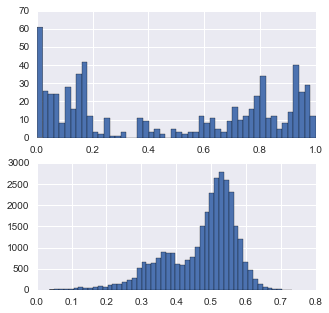

In [10]:
counts = BES_numeric.count()/BES_numeric.shape[0] # super slow!
counts_by_individuals = BES_numeric.count(axis=1)/BES_numeric.shape[1] # lets see
f, axarr = plt.subplots( 2 ,figsize=(5, 5) )
axarr[0].hist(counts,bins=50)
axarr[1].hist(counts_by_individuals,bins=50)

In [11]:
thresh = 0.33

mostly_not_filled_out = counts[counts<= (counts.max()*thresh)].index
mostly_filled_out     = counts[counts>  (counts.max()*thresh)].index

In [12]:
BES_min = BES_numeric[mostly_filled_out]
print(BES_min.shape)
missing_fraction = BES_min.isnull().sum().sum()/(BES_min.shape[0]*BES_min.shape[1])
print(missing_fraction)

(31409, 362)
0.2223548024117379


Wall time: 5min 20s


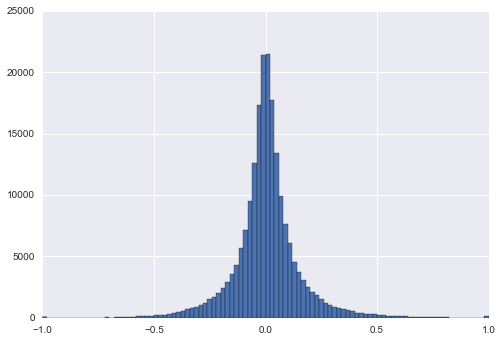

In [13]:
%%time
data = BES_numeric
corr_mat = data.corr()
# create lower triangle - diag mask
col_vars = len( corr_mat )
df = pd.DataFrame( np.arange(col_vars*col_vars).reshape(col_vars,col_vars) )
mask = np.ones(df.shape,dtype='bool')
mask[np.triu_indices(len(df))] = False
corr_mat.mask(~mask).stack().hist(bins=100)

In [14]:
corr_df = pd.DataFrame(columns = ["var1","var2","corr","var1%","var2%","min var%"])
# min_corr = []
id_num = 0

min_filled_out = 0.02

thresh = .05
x = ( ( corr_mat>(1-thresh) ) &mask ).values.nonzero()
# z = list( zip(corr_mat.columns[x[0]],corr_mat.columns[x[1]]) )
# z
for i in range( 0,len(x[0]) ):
    a = corr_mat.columns[ x[0][i] ]
    b = corr_mat.columns[ x[1][i] ]
    c = data[a].notnull().mean()
    d = data[b].notnull().mean()
    mincd = min(c,d)
    if mincd > min_filled_out and (a not in W9_vars) and (b not in W9_vars):
        corr_df.loc[id_num] = [ a,b,corr_mat[a][b], c, d, mincd ]
        id_num = id_num + 1


x = ( ( corr_mat<(thresh-1) ) &mask ).values.nonzero()
# z = list( zip(corr_mat.columns[x[0]],corr_mat.columns[x[1]]) )
# z
for i in range( 0,len(x[0]) ):
    a = corr_mat.columns[ x[0][i] ]
    b = corr_mat.columns[ x[1][i] ]
    c = data[a].notnull().mean()
    d = data[b].notnull().mean()
    mincd = min(c,d)
    if (mincd > min_filled_out) and (a not in W9_vars) and (b not in W9_vars):
        corr_df.loc[id_num] = [ a,b,corr_mat[a][b], c, d, mincd ]
        id_num = id_num + 1
#     print( ( a,b,corr_mat[a][b], c, d, min(c,d) ) )
#     min_corr.append( min(c,d) )
corr_df

,var1,var2,corr,var1%,var2%,min var%
0,euRefVote,euRefVotePost,1.000000,0.925372,0.125092,0.125092
1,partyContactUKIP_3,partyContactLD_3,1.000000,0.025439,0.024070,0.024070
2,euID,euRefVote,0.957034,0.159254,0.925372,0.159254
3,euRefVoteUnsqueeze,euRefVote,1.000000,0.756025,0.925372,0.756025
4,euRefVoteUnsqueeze,euID,0.965933,0.756025,0.159254,0.159254
5,euRefVote2,euRefVote,1.000000,0.800280,0.925372,0.800280
6,euRefVote2,euID,0.960398,0.800280,0.159254,0.159254
7,euRefVote2,euRefVoteUnsqueeze,1.000000,0.800280,0.756025,0.756025
8,ageGroup,age,0.975992,0.628896,1.000000,0.628896
9,Age,age,0.998577,0.807921,1.000000,0.807921


In [15]:
# corr_df.loc[~w9_rows,"min var%"][corr_df["min var%"]>.02].hist(bins=200)

In [16]:
# w9_rows = corr_df["var1"].apply(lambda x: x in W9_vars) | corr_df["var2"].apply(lambda x: x in W9_vars)
# corr_df.loc[~w9_rows][corr_df["min var%"]>.02]

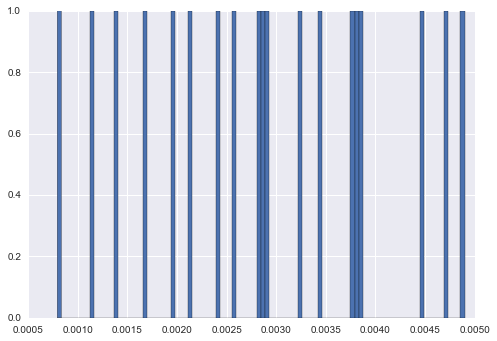

In [17]:
## TEST VARIANCES
a = BES_imputed.var()
b = a<a.quantile(.05)
a[b].hist(bins=100)
very_low_var = BES_imputed.columns[b]
# a.quantile(.01)

In [18]:
# drop columns below certain % filled out (2%)
# drop columns which are identical (drop least filled in) or directly derived
# make a list of derived columns??? -> scales

# WHAT TO REMOVE?
# W9_vars

# two_opt_cats

# many_cat_drop_list
# high_corr_drop_list

# mostly_not_filled_out
# mostly_filled_out

In [19]:
high_corr_drop_list = ['euRefVoteUnsqueeze', 'euRefVote2', 'euRefVotePost',
                       'ageGroup', 'Age', 'voted2015', "ns_sec" , 'recallVote15']

In [34]:
BES_reduced = BES_imputed.copy()
cols = BES_reduced.columns
print(BES_reduced.shape)

BES_reduced.drop(W9_vars,axis=1,errors='ignore',inplace=True)
print("W9_vars", BES_reduced.shape)
drop_cols = cols.difference(BES_reduced.columns)
if ( (len(drop_cols) >0) and (len(drop_cols) <= 10) ): print(drop_cols) 
cols = BES_reduced.columns

BES_reduced.drop(many_cat_drop_list,axis=1,errors='ignore',inplace=True)
print("many_cat_drop_list", BES_reduced.shape)
drop_cols = cols.difference(BES_reduced.columns)
if ( (len(drop_cols) >0) and (len(drop_cols) <= 10) ): print(drop_cols) 
cols = BES_reduced.columns

BES_reduced.drop(high_corr_drop_list,axis=1,errors='ignore',inplace=True)
print("high_corr_drop_list", BES_reduced.shape)
drop_cols = cols.difference(BES_reduced.columns)
if ( (len(drop_cols) >0) and (len(drop_cols) <= 10) ): print(drop_cols) 
cols = BES_reduced.columns

BES_reduced.drop(mostly_not_filled_out,axis=1,errors='ignore',inplace=True)
print("mostly_not_filled_out", BES_reduced.shape)
drop_cols = cols.difference(BES_reduced.columns)
if ( (len(drop_cols) >0) and (len(drop_cols) <= 10) ): print(drop_cols) 
cols = BES_reduced.columns

BES_reduced.drop(very_low_var,axis=1,errors='ignore',inplace=True) 
print("very_low_var", BES_reduced.shape)
drop_cols = cols.difference(BES_reduced.columns)
if ( (len(drop_cols) >0) and (len(drop_cols) <= 10) ): print(drop_cols) 
cols = BES_reduced.columns

(31409, 378)
W9_vars (31409, 378)
many_cat_drop_list (31409, 378)
high_corr_drop_list (31409, 378)
mostly_not_filled_out (31409, 239)
very_low_var (31409, 239)


In [35]:
def float_2_categorical(series,cat_dict):
    ser = series.astype('int')
    ser = ser.apply( lambda x : min( x , len( cat_dict ) - 1) )
    ser = ser.apply( lambda x : max( x , 0 ) )
    ser = ser.apply( lambda x: cat_dict[x] )  
    return ser


In [36]:
# Recreate and rename categorical non_ordinal and ordinal variables:
# ordinal two categories -> one single dummy binary variable labelled with positive category name (e.g gender_female)
# ordinal 3+ category variables just renamed to append "__top_value" to variable name
# non-ordinal 3+ categories -> split to individual dummy binary variables "category_subcateory"

# need to create a dict of new_variable_names with old col names
# to allow reinsertion of missing values, say
new_old_col_names = dict()

In [37]:
non_ordinal_list = var_type[ var_type["type"]==3 ].index.intersection(BES_reduced.columns)
for non_ordinal in non_ordinal_list:
    BES_reduced[non_ordinal] = float_2_categorical(BES_reduced[non_ordinal],
                                                   cat_dictionary[non_ordinal])       
    for subcat in cat_dictionary[non_ordinal]:
        new_col_name = non_ordinal + "_" + subcat
        new_old_col_names[new_col_name] = non_ordinal
        
BES_reduced = pd.get_dummies( BES_reduced, columns=non_ordinal_list )    

In [93]:
# non_ordinal
# cat_dictionary[non_ordinal]
# BES_numeric[non_ordinal].value_counts()
# a = round(BES_reduced[non_ordinal])\
#     .astype('int')
# a.value_counts()
# BES_reduced

In [38]:
two_opt_cats = opts_per_cat[opts_per_cat==2].index.intersection(BES_reduced.columns)
for col in two_opt_cats:
    BES_reduced[col] = BES_reduced[col]\
    .astype('int').apply( lambda x: cat_dictionary[col][x] )\
    .astype('category').cat.reorder_categories(cat_dictionary[col])
    new_col_name = col + "_" + cat_dictionary[col][1]
    new_old_col_names[new_col_name] = col
    
BES_reduced = pd.get_dummies( BES_reduced, columns=two_opt_cats, drop_first=True )

In [39]:
ordinal_list = var_type[ var_type["type"].apply(lambda x: x in [1,2,5]) ].index.intersection(BES_reduced.columns)
for ordinal in ordinal_list:
    new_col_name = ordinal + "__" + (cat_dictionary[ordinal])[-1:][0]
    BES_reduced.rename(columns={ordinal:new_col_name}, inplace=True)
    new_old_col_names[new_col_name] = ordinal
    
print("BES_reduced",BES_reduced.shape)

BES_reduced (31409, 456)


In [69]:
## We should do correlation testing on a version with missing values
## and may also wish an output with missing values (e.g. to run weightedPCA on)
## Which means reinserting missing values

BES_reduced_with_na = BES_reduced.copy()

for col in BES_reduced_with_na:
    if col in new_old_col_names.keys():
        old_col = new_old_col_names[col]
        null_series = BES_numeric[old_col].isnull()
    else:
        null_series = BES_numeric[col].isnull()
        
    BES_reduced_with_na[col][null_series] = np.nan
    
    # 2 option ordinal (name change)
    
    # 3+ option ordinal (name change)
    
    # categorical (split into lots of variables)
    
    # other (no name change)
    




riskScale
personality_agreeableness
personality_conscientiousness
personality_extraversion
personality_neuroticism
personality_openness


In [76]:
BES_reduced_with_na[col][~null_series]

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
5        0.0
6        0.0
7        0.0
8        0.0
9        0.0
10       0.0
11       0.0
12       0.0
13       0.0
14       0.0
15       0.0
16       0.0
17       0.0
18       0.0
19       0.0
20       0.0
21       0.0
22       0.0
23       0.0
24       0.0
25       0.0
26       0.0
27       0.0
28       0.0
29       0.0
        ... 
25346    0.0
25347    0.0
25348    0.0
25349    0.0
25350    0.0
25351    0.0
25352    0.0
25353    1.0
25354    0.0
25355    0.0
25356    1.0
25357    0.0
25358    0.0
25359    0.0
25360    0.0
25361    0.0
25362    0.0
25363    0.0
25364    0.0
25365    0.0
25366    1.0
25367    0.0
25368    0.0
25369    0.0
25370    0.0
25371    0.0
25372    1.0
25373    0.0
25374    0.0
25375    0.0
Name: profile_turnout_2015_No, did not vote, dtype: float64

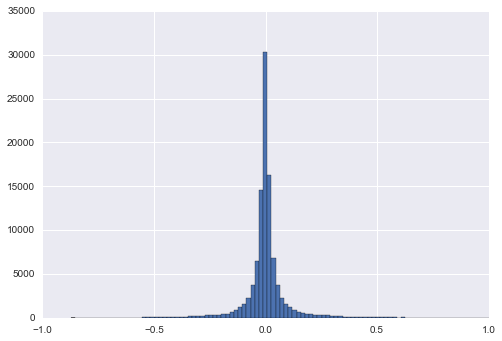

In [57]:
## TEST CORRELATIONS
data = BES_reduced_with_na
corr_mat = data.corr()
# create lower triangle - diag mask
col_vars = len( corr_mat )
df = pd.DataFrame( np.arange(col_vars*col_vars).reshape(col_vars,col_vars) )
mask = np.ones(df.shape,dtype='bool')
mask[np.triu_indices(len(df))] = False
corr_mat.mask(~mask).stack().hist(bins=100)

In [58]:
thresh = .05
x = ( ( corr_mat>(1-thresh) ) & mask ).values.nonzero()
# z = list( zip(corr_mat.columns[x[0]],corr_mat.columns[x[1]]) )
# z
for i in range( 0,len(x[0]) ):
    a = corr_mat.columns[ x[0][i] ]
    b = corr_mat.columns[ x[1][i] ]
    print( ( a,b,corr_mat[a][b], data[a].notnull().mean(), data[b].notnull().mean() ) )

x = ( ( corr_mat<(thresh-1) ) & mask ).values.nonzero()
# z = list( zip(corr_mat.columns[x[0]],corr_mat.columns[x[1]]) )
# z
for i in range( 0,len(x[0]) ):
    a = corr_mat.columns[ x[0][i] ]
    b = corr_mat.columns[ x[1][i] ]
    print( ( a,b,corr_mat[a][b], data[a].notnull().mean(), data[b].notnull().mean() ) )    

('gor_Scotland', 'country_Scotland', 1.0, 0.80792129644369448, 0.80792129644369448)
('gor_Wales', 'country_Wales', 1.0, 0.80792129644369448, 0.80792129644369448)


In [59]:
# high_corr_drop_list = ['country_Scotland', 'country_Wales', 'polKnowMay_Leader of the Labour Party',
                      # 'polKnowBercow_Home secretary', 'polKnowMiliband_Deputy Prime Minister']

dummy_cat_high_corr_drop_list = ['country_Scotland', 'country_Wales']
BES_reduced.drop( dummy_cat_high_corr_drop_list,axis=1, inplace=True, errors='ignore')
BES_reduced_with_na.drop( dummy_cat_high_corr_drop_list,axis=1, inplace=True, errors='ignore')
print("dummy_cat_high_corr_drop_list", BES_reduced.shape)
print(dummy_cat_high_corr_drop_list)

dummy_cat_high_corr_drop_list (31409, 454)
['country_Scotland', 'country_Wales']


In [99]:
# very_low_var
# NoiseVariance.loc[very_low_var].sort_values(by='noise_variance_')fc

# upshot - get rid of 

In [61]:
BES_reduced.to_hdf(BES_data_folder+"BES_reduced.hdf","BES_reduced")

In [62]:
BES_reduced_with_na.to_hdf(BES_data_folder+"BES_reduced_with_na.hdf","BES_reduced_with_na")